In [ ]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.font_manager as fm


In [2]:
# input survey data
file_path = "data/laurelhurst_survey_with_address.csv"  
df = pd.read_csv(file_path)

# input all residents data
all_residents_file = "data/laurelhurst_address.csv"
all_residents_df = pd.read_csv(all_residents_file)
print(len(all_residents_df))

1873


# Generate social tie network

In [3]:


def _get_degree_list(n, para=[17.40150274, -0.57925534], seed=0):
    """
    Method:
        Generate the degree list of each household.
    Parameters:
        n: the number of households
    Return:
        degree_list: the degree list of each household
    """
    np.random.seed(seed)
    # Negative binomial distribution
    degree_list = np.random.negative_binomial(n=para[0], p=para[1], size=n)

    return degree_list

def _distance_decay_function(distance, alpha=-1.35):
    """
    Method:
        The distance decay function is used to calculate the probability of two households having a tie.
    Parameters:
        distance: the distance between two households
        alpha: the decay rate
    return:
        the probability of two households having a tie
    Reference:
        alpha values:
        (alpha = -1.2) Liben-Nowell, D., Novak, J., Kumar, R., Raghavan, P., Tomkins, A., 2005. Geographic routing in social networks. 
            Proceedings of the National Academy of Sciences 102, 11623–11628.
        (alpha = -0.74) Xu, Y., Santi, P., & Ratti, C. (2022). Beyond distance decay: Discover homophily in spatially embedded social networks. 
            Annals of the American Association of Geographers, 112(2), 505-521.
    """
    eps = 1e-12 # to avoid division by zero
    return (distance + eps) ** alpha

def _get_social_tie_matrix(probability_np, degree_list, seed=0):
    """
    Method:
        Get the social tie matrix.
    Parameters:
        probability_np: the probability matrix
        degree_list: the degree of each household
    Return:
        the social tie matrix
    """
    assert np.shape(probability_np)[0] == len(degree_list)
    np.random.seed(seed)

    # make sure the sum of degree is even
    if degree_list.sum() % 2 != 0:
        degree_list[0] += 1

    social_tie_matrix = np.zeros(probability_np.shape, dtype=int)
    accumulated_degree_list = np.zeros(len(degree_list), dtype=int)

    for i in range(np.shape(probability_np)[0]):
        remain_degree = degree_list - accumulated_degree_list # the number of remaining degree for each household
        if remain_degree[i] <= 0:
            continue
        reachable_households = np.where(remain_degree > 0)[0] # the households that are reachable from household i
        select_probability = probability_np[i, reachable_households]/np.sum(probability_np[i, reachable_households])
        selected_households = np.random.choice(reachable_households, 
                                           size=remain_degree[i], 
                                           p=select_probability,
                                           replace=True)
        # This function still contains a problem. To be strict, replace should be False.
        # However, in that case, the degree requirement is very likely not satisfied.
        # This problem is a standalone network generation problem. 
        social_tie_matrix[i, selected_households] = 1
        social_tie_matrix[selected_households, i] = 1
        accumulated_degree_list = np.sum(social_tie_matrix, axis=1)
    return social_tie_matrix

def _split_social_tie_matrix(social_tie_matrix, p=0.41296054954979877, seed=0):
    """
    Method:
        Split the network into two subnetworks, i.e., stong ties, weak ties, and strangers.
    Parameters:
        social_tie_matrix: the social tie matrix.
        p: the proportion of strong ties among all ties. The proportion of weak ties is 1 - p.
    Return:
        strong_tie_matrix: the strong tie matrix
        weak_tie_matrix: the weak tie matrix
        stranger_tie_matrix: the stranger tie matrix
    """
    assert np.shape(social_tie_matrix)[0] == np.shape(social_tie_matrix)[1]
    assert p >= 0 and p <= 1

    np.random.seed(seed)

    strong_tie_matrix = np.zeros(np.shape(social_tie_matrix), dtype=int)
    upper_triangle = np.triu(social_tie_matrix, k=1)
    for i in range(np.shape(upper_triangle)[0]):
        for j in range(np.shape(upper_triangle)[1]):
            if upper_triangle[i, j] == 1:
                if np.random.uniform() < p:
                    strong_tie_matrix[i, j] = 1
                    strong_tie_matrix[j, i] = 1
    weak_tie_matrix = social_tie_matrix - strong_tie_matrix
    stranger_tie_matrix = np.ones(np.shape(social_tie_matrix), dtype=int) - social_tie_matrix
    np.fill_diagonal(stranger_tie_matrix, 0)
    return strong_tie_matrix, weak_tie_matrix, stranger_tie_matrix

def get_social_network(distance_matrix, prop_fri, degree_para, dist_decay_alpha, seed=0, degree_ratio=1.0):
    """
    Method:
        Generate a social network based on the distance matrix and the proportion of friends.
    Parameters:
        distance_matrix: the distance matrix
        prop_fri: the proportion of friends
        degree_para: the parameters of the degree distribution
        dist_decay_alpha: the decay rate of the distance decay function
        seed: the random seed
        degree_ratio: the ratio of the degree
    Return:
        strong_tie_matrix: the strong tie matrix
        weak_tie_matrix: the weak tie matrix
        stranger_tie_matrix: the stranger tie matrix
    """

    degree_list = _get_degree_list(np.shape(distance_matrix)[0], degree_para, seed=seed)
    degree_list = np.rint(degree_list * degree_ratio).astype(int)
    probability_np = _distance_decay_function(distance_matrix, dist_decay_alpha)
    social_tie_matrix = _get_social_tie_matrix(probability_np, degree_list, seed=seed)
    strong_tie_matrix, weak_tie_matrix, stranger_tie_matrix = _split_social_tie_matrix(social_tie_matrix, prop_fri, seed=seed)

    return strong_tie_matrix, weak_tie_matrix, stranger_tie_matrix

In [4]:
distance_matrix = np.load("data/laurelhurst_distance_matrix.npy")
strong_tie_matrix, weak_tie_matrix, stranger_matrix = get_social_network(distance_matrix, 
                                                                            prop_fri = 0.41296054954979877,
                                                                            degree_para=[0.7877, 0.0256],
                                                                            dist_decay_alpha=-1.35)

In [5]:
new_strong_tie = strong_tie_matrix.sum(axis=1)
new_weak_tie = weak_tie_matrix.sum(axis=1)

In [6]:
all_residents_df['strong_tie'] = new_strong_tie
all_residents_df['weak_tie'] = new_weak_tie

In [7]:
print(all_residents_df)

        ID  CLUSTER           PIN                      TAXPAYER NAME  \
0        0        1  4.217402e+09  GOULD STEVEN D                      
1        1        1  4.217402e+09  MAHER T DEAN                        
2        2        1  4.217402e+09  ATTERBURY CHARLES AND SHERR         
3        3        1  4.217402e+09  QUIGLEY TERENCE M+TRACY Q           
4        4        1  4.217402e+09  MCCOY KATHLEEN ET AL                
...    ...      ...           ...                                ...   
1868  1868       95           NaN                                NaN   
1869  1869       95           NaN                                NaN   
1870  1870       95           NaN                                NaN   
1871  1871       95           NaN                                NaN   
1872  1872       95           NaN                                NaN   

                        ADDRESS     CITY    ZIP  passcode   latitude  \
0     3057 E LAURELHURST DR NE   SEATTLE  98105       NaN  47.6

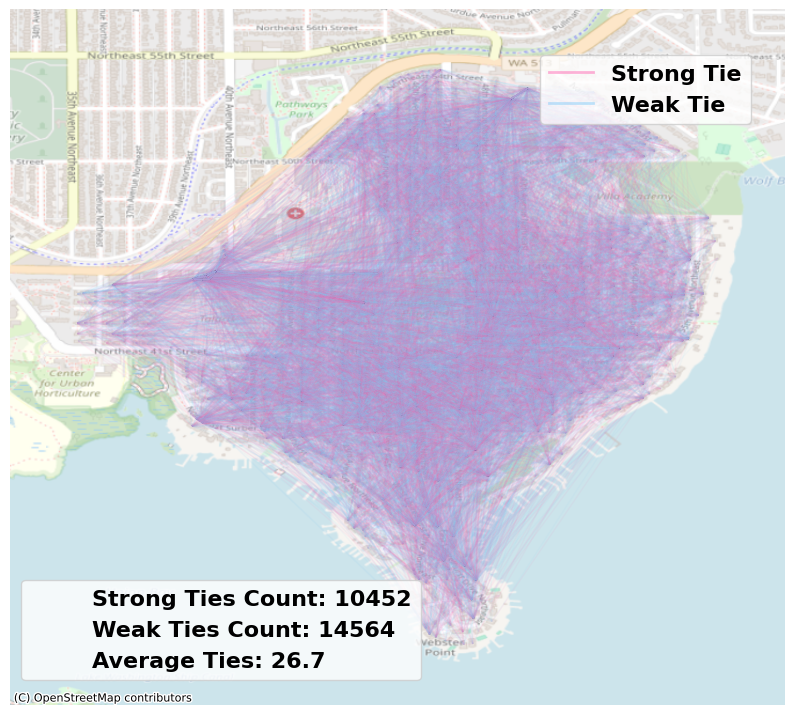

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import networkx as nx
import geopandas as gpd
import contextily as cx
import pandas as pd
import numpy as np


font_bold_large = fm.FontProperties(weight='bold', size=16)
font_bold_medium = fm.FontProperties(weight='bold', size=12)


geometry = gpd.points_from_xy(all_residents_df['longitude'], all_residents_df['latitude'])
gdf = gpd.GeoDataFrame(all_residents_df, geometry=geometry)
gdf.crs = "EPSG:4326"


G = nx.Graph()


for index, row in gdf.iterrows():
    G.add_node(index, pos=(row['longitude'], row['latitude']))


for i in range(len(strong_tie_matrix)):
    for j in range(len(strong_tie_matrix[i])):
        if strong_tie_matrix[i][j] == 1:
            G.add_edge(i, j, color='hotpink', alpha=1) 
        elif weak_tie_matrix[i][j] == 1:
            G.add_edge(i, j, color='lightskyblue', alpha=1)  

fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.get_node_attributes(G, 'pos')
edges = G.edges()
colors = [G[u][v]['color'] for u, v in edges]

nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, alpha=0.06, ax=ax)


cx.add_basemap(ax, crs=gdf.crs.to_string(), alpha=0.6, source=cx.providers.OpenStreetMap.Mapnik)


# cx.add_basemap(ax, crs=gdf.crs.to_string(), alpha=0.6, source=cx.providers.Stamen.Terrain)

# cx.add_basemap(ax, source=cx.providers.Esri.WorldStreetMap, crs='EPSG:4326')


total_strong_ties = np.sum(strong_tie_matrix) / 2 
total_weak_ties = np.sum(weak_tie_matrix) / 2
average_ties = (total_strong_ties + total_weak_ties) / len(G.nodes())*2


legend1_lines = [plt.Line2D([0], [0], color='hotpink', lw=2, alpha=0.5, label='Strong Tie'),
                 plt.Line2D([0], [0], color='lightskyblue', lw=2, alpha=0.5, label='Weak Tie')]
legend1 = ax.legend(handles=legend1_lines, loc='upper right', bbox_to_anchor=(0.97, 0.95), prop=font_bold_large)


legend2_lines = [plt.Line2D([0], [0], color='none', marker='o', markersize=0, label=f'Strong Ties Count: {total_strong_ties:.0f}'),
                 plt.Line2D([0], [0], color='none', marker='o', markersize=0, label=f'Weak Ties Count: {total_weak_ties:.0f}'),
                 plt.Line2D([0], [0], color='none', marker='o', markersize=0, label=f'Average Ties: {average_ties:.1f}')]
legend2 = ax.legend(handles=legend2_lines, loc='lower left', bbox_to_anchor=(0, 0.02), prop=font_bold_large)


ax.add_artist(legend1)

plt.axis('off')
plt.show()


# Social captial value

In [9]:
# sharing preference
columns_to_sum = ['7_water']

df['sharing_preference'] = df[columns_to_sum].sum(axis=1)

# print(df.head())


# data normalization
columns_to_extract = ['sharing_preference']

for column in columns_to_extract:
    
    column_data = df[column]
    column_normalized = (column_data - column_data.min()) / (column_data.max() - column_data.min())

    full_series = pd.Series(0, index=np.arange(len(all_residents_df)))

    full_series.iloc[:len(column_normalized)] = column_normalized

    sorted_data = sorted(column_normalized)
    cdf_values = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    for i in range(len(column_normalized), len(all_residents_df)):
        full_series.at[i] = np.interp(np.random.rand(), cdf_values, sorted_data)

    all_residents_df[column + '_new'] = full_series

In [10]:
all_residents_df['social_ties'] = all_residents_df[['strong_tie','weak_tie']].sum(axis=1)

In [11]:
# all_residents_df['social_ties'].min()

In [12]:
# all_residents_df['social_ties'].max()

In [13]:
# all_residents_df['social_ties'].mean()

In [14]:
# all_residents_df['social_ties'].std()

In [15]:

columns_to_extract = ['social_ties']

for column in columns_to_extract:

    column_data = all_residents_df[column]
#     print(column_data.min(),column_data.max())
    column_normalized = (column_data - column_data.min()) / (column_data.max() - column_data.min())

    full_series = pd.Series(0, index=np.arange(len(all_residents_df)))

    full_series.iloc[:len(column_normalized)] = column_normalized

    sorted_data = sorted(column_normalized)
    cdf_values = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    for i in range(len(column_normalized), len(all_residents_df)):
        full_series.at[i] = np.interp(np.random.rand(), cdf_values, sorted_data)

    all_residents_df[column + '_new'] = full_series

# print(df.head())


In [16]:
# df['11_hours'].max()

In [17]:
# df['11_hours'].min()

In [18]:
# df['11_hours'].mean()

In [19]:
# df['11_hours'].std()

In [20]:
# participation ("11_hours" is the answer of Q11: how many hours you participate in community activity)

columns_to_extract = ['11_hours']

for column in columns_to_extract:
    
    column_data = df[column]
    column_normalized = (column_data - column_data.min()) / (column_data.max() - column_data.min())

    full_series = pd.Series(0, index=np.arange(len(all_residents_df)))

    full_series.iloc[:len(column_normalized)] = column_normalized

    sorted_data = sorted(column_normalized)
    cdf_values = np.arange(1, len(sorted_data)+1) / len(sorted_data)
    for i in range(len(column_normalized), len(all_residents_df)):
        full_series.at[i] = np.interp(np.random.rand(), cdf_values, sorted_data)

    all_residents_df['participation_new'] = full_series

In [21]:

columns_to_extract = ['sharing_preference_new', 'social_ties_new','participation_new']
df_normalized = all_residents_df[columns_to_extract]

print(df_normalized)


      sharing_preference_new  social_ties_new  participation_new
0                   1.000000         0.102564           0.000000
1                   0.333333         0.055556           0.100000
2                   0.666667         0.500000           0.040000
3                   0.666667         0.064103           0.240000
4                   0.666667         0.004274           0.100000
...                      ...              ...                ...
1868                0.333333         0.145299           0.000000
1869                0.333333         0.170940           0.000000
1870                0.333333         0.047009           0.035582
1871                0.333333         0.029915           0.100000
1872                0.000000         0.055556           0.050000

[1873 rows x 3 columns]


In [22]:

weights = {
    'sharing_preference_new':1/3, 
    'social_ties_new':1/3,
    'participation_new':1/3,
}


df_normalized['sum'] = df_normalized.dot(pd.Series(weights))


mean_value = df_normalized['sum'].mean()
# print("Average:", mean_value)

variance_value = df_normalized['sum'].var()
# print("Variance:", variance_value)

min_val = df_normalized['sum'].min()
max_val = df_normalized['sum'].max()

bins = np.arange(np.floor(min_val), np.ceil(max_val) + 0.1, 0.1)

categories = pd.cut(df_normalized['sum'], bins)

frequency_distribution = categories.value_counts().sort_index()

# print('frequency_distribution',frequency_distribution)


/var/folders/kq/64hp13jd2zq8t3jms3pzw0ww0000gn/T/ipykernel_21426/1828547315.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['sum'] = df_normalized.dot(pd.Series(weights))


/var/folders/kq/64hp13jd2zq8t3jms3pzw0ww0000gn/T/ipykernel_21426/984713859.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


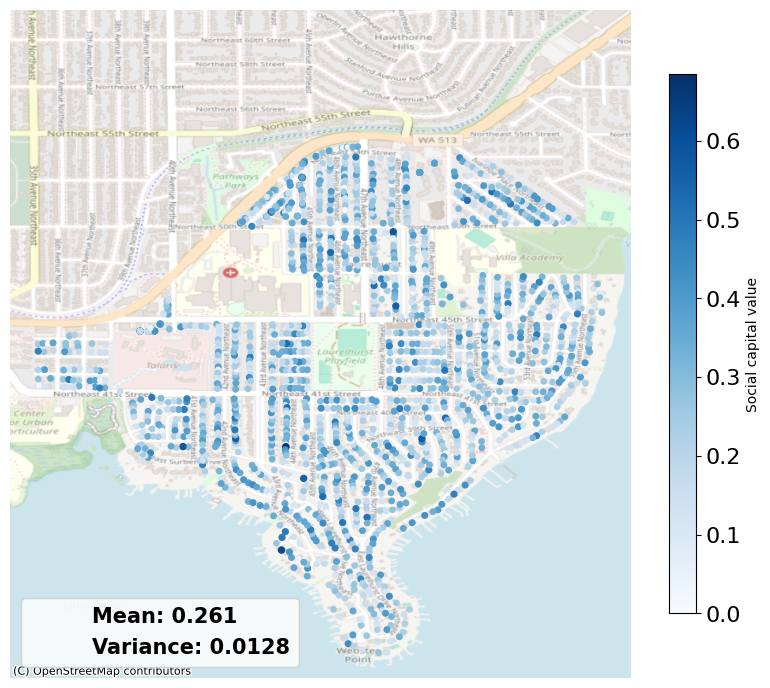

In [23]:
# font = fm.FontProperties(family='Calibri', size=16)
# figure

legend_font = fm.FontProperties(weight='bold', size=16)

node_list = all_residents_df['passcode'].tolist()
node_pos = all_residents_df[['longitude', 'latitude']].values

geometry = gpd.points_from_xy(node_pos[:,0], node_pos[:,1])
gdf = gpd.GeoDataFrame(all_residents_df, geometry=geometry)
gdf.crs = "epsg:4326"

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')  


cmap = plt.cm.get_cmap('Blues') 
node_color = df_normalized['sum'] / df_normalized['sum'].max() 


size_factor = 10
node_size = (df_normalized['sum'] / df_normalized['sum'].max()) * size_factor + 10

sc = ax.scatter(node_pos[:,0], node_pos[:,1], s=node_size, c=node_color, cmap=cmap, alpha=1)


y_lim_upper = ax.get_ylim()[1]
ax.set_ylim(ax.get_ylim()[0], y_lim_upper + 0.2 * (y_lim_upper - ax.get_ylim()[0]))


# cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.Stamen.TonerLite)
# cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron, alpha=1) 
cx.add_basemap(ax, crs=gdf.crs.to_string(), alpha=0.6, source=cx.providers.OpenStreetMap.Mapnik)


# cx.add_basemap(ax, crs=gdf.crs.to_string(), alpha=0.6, source=cx.providers.Stamen.Terrain)

# cx.add_basemap(ax, source=cx.providers.Esri.WorldStreetMap, crs='EPSG:4326')


ax.grid(False)


sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(df_normalized['sum'])
cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Social capital value')



cbar.ax.tick_params(labelsize=16)  

mean_line = mlines.Line2D([], [], color='none', marker='o', markersize=0, 
                          label=f"Mean: {mean_value:.3f}")  
variance_line = mlines.Line2D([], [], color='none', marker='o', markersize=0, 
                              label=f"Variance: {variance_value:.4f}")


leg = ax.legend(handles=[mean_line, variance_line], loc='lower left', prop=legend_font)

for text in leg.get_texts():
    text.set_color("black")
    text.set_fontsize(15)


ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')
plt.savefig('output_image.png', bbox_inches='tight')
plt.show()